In [14]:
from __future__ import division
import argparse
import torch
import torch.nn.functional as F
import torchvision.datasets as dset
import torchvision.transforms as T
import torchvision.models as models
import pandas as pd
import os
import pydicom
import numpy as np
import h5py
import time
from tqdm import tqdm as tqdm
import cv2
import pickle
from shutil import copyfile
from matplotlib import pyplot as plt
import seaborn as sns
import random
from torch import nn
from torch.autograd import Variable

Image Level
===========

In [44]:
class StudyLevelDataset(torch.utils.data.Dataset):
    """Kaggle PE dataset."""

    def __init__(self, csv_file, stage):
        """
        Args:
            csv_file (string): Path to the csv file.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.pedataframe = pd.read_csv(csv_file)
        
        self.hdf5_filename1 = '/scratch/efficientb0_features.hdf5'
        self.hdf5_filename2 = '/scratch/resnet_features.hdf5'
        #self.hdf5_filename2 = '/scratch/combined_features.hdf5'
        
        self._generate_row_indices_list()
        
        self.stage = stage
        
        if self.stage == 'train':
            self.start = 0
            self.end = 2650
        else:
            self.start = 2660
            self.end = 3500
        
        # 0 - 2650 train
        # 2660 - 3500 valid

    def __len__(self):
        """ Return number of 2D images. (Each CT slice is an independent image.)"""
        #return len(self.pedataframe)
        return self.end - self.start + 1
        #return num_pos_samples_per_dataset + num_neg_samples_per_dataset
        
    def _generate_row_indices_list(self):
        # group slice indices into studies
        self.row_indices = [] # index into train df for every study
        current_study_id = ''

        for slice_index in range(len(self.pedataframe)):
            new_study_id = self.pedataframe.StudyInstanceUID[slice_index]
            if new_study_id != current_study_id:
                self.row_indices.append(slice_index)
                current_study_id = new_study_id
            if slice_index % 100000 == 0:
                print(slice_index)
        
    def __getitem__(self, study_index):
        '''  '''
        study_index = study_index + self.start
        
        h5py_file1 = h5py.File(self.hdf5_filename1, "r")
        h5py_file2 = h5py.File(self.hdf5_filename2, "r")
        
        start_index = self.row_indices[study_index]
        if study_index+1 < len(self.row_indices):
            stop_index = self.row_indices[study_index+1]
        else:
            stop_index = len(self.pedataframe)
            
        # dim: seq_len x embedding_dim
        x = np.ones((stop_index-start_index, 3328))  #embedding dim = 1280 for efficientnetb0 resnet 2048 1280+2048=3328
        y = np.ones(stop_index-start_index)
            
        for slice_index in range(start_index, stop_index):
            data_identifier = 'tensor(' + str(slice_index) + ')'
            #slice_embeddings = h5py_file1[data_identifier][:].copy()
            #slice_embeddings.append(h5py_file2[data_identifier][:])
            #slice_embeddings[:len(h5py_file2[data_identifier][:])] += h5py_file2[data_identifier][:]
            slice_embeddings = np.concatenate((h5py_file1[data_identifier][:], h5py_file2[data_identifier][:]),axis=0)
            x[slice_index-start_index,:] = slice_embeddings
            
            pe_present_on_image = float(int(self.pedataframe.pe_present_on_image[slice_index]))
            y[slice_index-start_index] = pe_present_on_image
        
        h5py_file1.close()
        h5py_file2.close()
        
        return x, y

In [45]:
hdf5_filename1 = '/scratch/efficientb0_features.hdf5'
h5py_file1 = h5py.File(hdf5_filename1, "r")
h5py_file1['tensor(12)'][:]

h5py_file1.close()

hdf5_filename2 = '/scratch/resnet_features.hdf5'
h5py_file2 = h5py.File(hdf5_filename2, "r")
h5py_file2['tensor(12)'][:]

h5py_file2.close()

In [46]:
data_dir = '/projectnb/ece601/kaggle-pulmonary-embolism/rsna-str-pulmonary-embolism-detection/'
train_csv = data_dir + 'train.csv'
train_dir = data_dir + 'train/'
train_dataset = StudyLevelDataset(csv_file=train_csv, stage='train')
valid_dataset = StudyLevelDataset(csv_file=train_csv, stage='valid')

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000


In [41]:
'''
https://towardsdatascience.com/taming-lstms-variable-sized-mini-batches-and-why-pytorch-is-good-for-your-health-61d35642972e
'''

batch_size = 1
embedding_dim = 3328
nb_lstm_units = 64

class MyLSTM(nn.Module):
    def __init__(self, nb_layers=1, nb_lstm_units=nb_lstm_units, 
                 embedding_dim=embedding_dim, batch_size=batch_size):
        
        super(MyLSTM, self).__init__()

        self.nb_layers = nb_layers
        self.nb_lstm_units = nb_lstm_units
        self.embedding_dim = embedding_dim
        self.batch_size = batch_size

        self.lstm = nn.LSTM(
            input_size=self.embedding_dim,
            hidden_size=self.nb_lstm_units,
            num_layers=self.nb_layers,
            batch_first=True
        )

        # output layer
        self.linear = nn.Linear(self.nb_lstm_units, 1)

    def init_hidden(self):
        # the weights are of the form (nb_layers, batch_size, nb_lstm_units)
        hidden_h0 = torch.randn(self.nb_layers, self.batch_size, self.nb_lstm_units)
        hidden_c0 = torch.randn(self.nb_layers, self.batch_size, self.nb_lstm_units)

        hidden_h0 = hidden_h0.to(device)
        hidden_c0 = hidden_c0.to(device)

        hidden_h0 = Variable(hidden_h0)
        hidden_c0 = Variable(hidden_c0)

        return (hidden_h0.to(device), hidden_c0.to(device))
    
    def forward(self, X):
        # reset the LSTM hidden state. Must be done before you run a new batch. Otherwise the LSTM will treat
        # a new batch as a continuation of a sequence
        self.hidden = self.init_hidden()

        batch_size, seq_len, _ = X.size()

        # pack_padded_sequence so that padded items in the sequence won't be shown to the LSTM
        #X = torch.nn.utils.rnn.pack_padded_sequence(x, X_lengths, batch_first=True)

        # now run through LSTM
        X, self.hidden = self.lstm(X, self.hidden)

        # undo the packing operation
        #X, _ = torch.nn.utils.rnn.pad_packed_sequence(X, batch_first=True)

        # this one is a bit tricky as well. First we need to reshape the data so it goes into the linear layer
        X = X.contiguous()
        X = X.view(-1, X.shape[2])

        # run through actual linear layer
        X = self.linear(X)

        # ---------------------
        # 4. Create softmax activations bc we're doing classification
        # Dim transformation: (batch_size * seq_len, nb_lstm_units) -> (batch_size, seq_len, nb_tags)
        #X = torch.sigmoid(X)

        # I like to reshape for mental sanity so we're back to (batch_size, seq_len, nb_tags)
        X = X.view(batch_size, seq_len)

        Y_hat = X
        return Y_hat

In [42]:
model = MyLSTM()
model

MyLSTM(
  (lstm): LSTM(3328, 64, batch_first=True)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)

In [47]:
device = 'cpu'
model.to(device)
x,y = train_dataset[1]
x = torch.tensor(x)
x = x.unsqueeze(0).float()
x = x.to(device)

pred = model(x)

In [48]:
bce = torch.nn.BCEWithLogitsLoss()
def criterion(logits, target):
    loss = bce(logits.view(-1), target.view(-1))
    return loss

dummy = None

def train_epoch(model, loader, optimizer):

    model.train()
    train_loss = []
    bar = tqdm(loader)
    for (data, target) in bar:
        data, target = data.to(device), target.to(device)
        
        # zero gradients
        optimizer.zero_grad()

        #forward pass
        logits = model(data.float())
        
        # calculate loss
        loss = criterion(logits, target)

        # backpropagate the loss (backward pass)
        loss.backward()
 
        # update parameters based on accumulated gradients
        optimizer.step()

        loss_np = loss.detach().cpu().numpy()

        train_loss.append(loss_np)
        average_loss = sum(train_loss) / len(train_loss)
        bar.set_description('loss: %.5f, mean: %.5f' % (loss_np, average_loss))

    return float(average_loss)

def valid_epoch(model, loader):
    model.eval()
    val_loss = []
    pos_logits = []
    neg_logits = []

    with torch.no_grad():
        for (data, target) in tqdm(loader):
            data, target = data.to(device), target.to(device)
            logits = model(data.float())

            loss = criterion(logits, target)

            loss_np = loss.detach().cpu().numpy()

            val_loss.append(float(loss_np))

            logits = logits.squeeze()
            target = target.squeeze()
            
            for i in range(logits.shape[-1]):
                b = target[i].detach().cpu().numpy()
                if b == 1:
                    pos_logits.append(float(logits[i].detach().cpu().numpy()))
                else:
                    neg_logits.append(float(logits[i].detach().cpu().numpy()))
                    
    val_loss_mean = sum(val_loss) / len(val_loss)
    
    neg_logits_tensor = torch.FloatTensor(neg_logits).cuda()
    pos_logits_tensor = torch.FloatTensor(pos_logits).cuda()
    
    neg_loss = criterion(neg_logits_tensor, torch.zeros(neg_logits_tensor.shape).float().cuda())
    pos_loss = criterion(pos_logits_tensor, torch.ones(pos_logits_tensor.shape).float().cuda())
    
    neg_loss = neg_loss.detach().cpu().numpy()
    pos_loss = pos_loss.detach().cpu().numpy()
    
    neg_mean = float(torch.sigmoid(neg_logits_tensor).mean().detach().cpu().numpy())
    pos_mean = float(torch.sigmoid(pos_logits_tensor).mean().detach().cpu().numpy())
    
    return float(val_loss_mean), float(pos_loss), float(neg_loss), pos_mean, neg_mean

def get_optimizer(lr, model):
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=0.0001)
    return optimizer

init_lr = 0.1
n_epochs = 20
device = 'cuda'

# reduce LR by gamma three times every 10 epochs
# each epoch is 100,000 samples
#gamma = 10
#schedule = [10, 20, 30]

#model = resnext101.to(device)
optimizer = get_optimizer(init_lr, model)
model.to(device)

master_train_loss = []
master_valid_loss = []
epoch = 1
#best_valid_loss = 10


while epoch <= n_epochs:
    print(time.ctime(), 'Epoch:', epoch)
    
    # update learning rate 
    #if epoch in schedule:
    #    new_lr = optimizer.param_groups[0]["lr"] / gamma
     #   optimizer = get_optimizer(new_lr, model)
    
    #train_loader, valid_loader = get_loaders(epoch)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1,num_workers=1)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=1,num_workers=1)

    # train
    train_loss = train_epoch(model, train_loader, optimizer)
    optimizer.zero_grad()
    
    # validate
    valid_loss, pos_loss, neg_loss, pos_mean, neg_mean = valid_epoch(model, valid_loader)
    #valid_loss = 0
    #pos_loss  = 0
    #neg_loss = 0
    #pos_mean = 0
    #neg_mean = 0
    
    content = time.ctime() + ' ' + f'Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {np.mean(train_loss):.5f}, valid loss: {(valid_loss):.5f}'
    print(content)
    content = f'pos loss: {(pos_loss):.5f}, neg loss: {(neg_loss):.5f}, pos mean: {(pos_mean):.5f}, neg mean {(neg_mean):.5f}'
    print(content)
    master_train_loss.append(train_loss)
    master_valid_loss.append(valid_loss)
    
    # save loss data and model weights
    #with open('train_loss.pkl', 'wb') as f:
        #pickle.dump(master_train_loss, f)
    #with open('valid_loss.pkl', 'wb') as f:
        #pickle.dump(master_valid_loss, f)
        
        #torch.save(model.state_dict(), 'model-resnext-50-{}.pth'.format(epoch))
        #best_valid_loss = valid_loss
    
    epoch += 1
           

  0%|          | 0/2651 [00:00<?, ?it/s]

Tue Dec  8 17:45:30 2020 Epoch: 1


  0%|          | 0/2651 [00:00<?, ?it/s]

Tue Dec  8 17:54:52 2020 Epoch 1, lr: 0.1000000, train loss: 0.11461, valid loss: 0.11209
pos loss: 0.97172, neg loss: 0.06368, pos mean: 0.51804, neg mean 0.05103
Tue Dec  8 17:54:52 2020 Epoch: 2


  0%|          | 0/2651 [00:00<?, ?it/s]

Tue Dec  8 18:03:55 2020 Epoch 2, lr: 0.1000000, train loss: 0.10918, valid loss: 0.10976
pos loss: 0.92341, neg loss: 0.06382, pos mean: 0.53065, neg mean 0.05113
Tue Dec  8 18:03:55 2020 Epoch: 3


  0%|          | 0/2651 [00:00<?, ?it/s]

Tue Dec  8 18:13:15 2020 Epoch 3, lr: 0.1000000, train loss: 0.10697, valid loss: 0.10674
pos loss: 0.89275, neg loss: 0.06235, pos mean: 0.54331, neg mean 0.05005
Tue Dec  8 18:13:15 2020 Epoch: 4


  0%|          | 0/2651 [00:00<?, ?it/s]

Tue Dec  8 18:22:30 2020 Epoch 4, lr: 0.1000000, train loss: 0.10440, valid loss: 0.10176
pos loss: 0.93432, neg loss: 0.05487, pos mean: 0.52761, neg mean 0.04419
Tue Dec  8 18:22:30 2020 Epoch: 5


  0%|          | 0/2651 [00:00<?, ?it/s]

Tue Dec  8 18:31:41 2020 Epoch 5, lr: 0.1000000, train loss: 0.10303, valid loss: 0.10105
pos loss: 1.01042, neg loss: 0.05002, pos mean: 0.49458, neg mean 0.04109
Tue Dec  8 18:31:41 2020 Epoch: 6


  0%|          | 0/2651 [00:00<?, ?it/s]

Tue Dec  8 18:40:52 2020 Epoch 6, lr: 0.1000000, train loss: 0.10319, valid loss: 0.10107
pos loss: 0.93751, neg loss: 0.05401, pos mean: 0.52824, neg mean 0.04355
Tue Dec  8 18:40:52 2020 Epoch: 7


  0%|          | 0/2651 [00:00<?, ?it/s]

Tue Dec  8 18:50:08 2020 Epoch 7, lr: 0.1000000, train loss: 0.10273, valid loss: 0.10037
pos loss: 0.93675, neg loss: 0.05333, pos mean: 0.52664, neg mean 0.04330
Tue Dec  8 18:50:08 2020 Epoch: 8


  0%|          | 0/2651 [00:00<?, ?it/s]

Tue Dec  8 18:59:19 2020 Epoch 8, lr: 0.1000000, train loss: 0.10226, valid loss: 0.09905
pos loss: 0.93840, neg loss: 0.05192, pos mean: 0.53407, neg mean 0.04169
Tue Dec  8 18:59:19 2020 Epoch: 9


  0%|          | 0/2651 [00:00<?, ?it/s]

Tue Dec  8 19:08:32 2020 Epoch 9, lr: 0.1000000, train loss: 0.10136, valid loss: 0.09756
pos loss: 0.95502, neg loss: 0.04942, pos mean: 0.53320, neg mean 0.03954
Tue Dec  8 19:08:32 2020 Epoch: 10


  0%|          | 0/2651 [00:00<?, ?it/s]

Tue Dec  8 19:17:46 2020 Epoch 10, lr: 0.1000000, train loss: 0.10139, valid loss: 0.09846
pos loss: 0.95415, neg loss: 0.05047, pos mean: 0.52921, neg mean 0.04068
Tue Dec  8 19:17:46 2020 Epoch: 11


loss: 0.01318, mean: 0.13482:   2%|▏         | 51/2651 [00:05<04:52,  8.88it/s]


KeyboardInterrupt: 

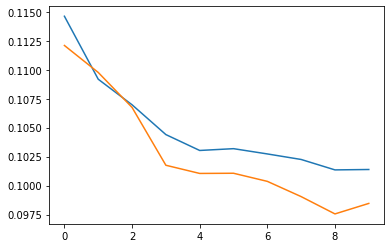

In [49]:
torch.save(model.state_dict(), 'model-combined-lstm1.pth')
plt.plot(master_train_loss[:], label='train')
plt.plot(master_valid_loss[:], label='valid')

Study Level Metrics
===============

In [50]:
class StudyLevelDataset2(torch.utils.data.Dataset):
    """Kaggle PE dataset."""

    def __init__(self, csv_file, stage):
        """
        Args:
            csv_file (string): Path to the csv file.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.pedataframe = pd.read_csv(csv_file)
        
        #self.hdf5_filename = '/scratch/features.hdf5'
        self.hdf5_filename1 = '/scratch/efficientb0_features.hdf5'
        self.hdf5_filename2 = '/scratch/resnet_features.hdf5'
        
        self._generate_row_indices_list()
        
        self.stage = stage
        
        if self.stage == 'train':
            self.start = 0
            self.end = 2650
        else:
            self.start = 2660
            self.end = 3500
        
        # 0 - 2650 train
        # 2660 - 3500 valid

    def __len__(self):
        """ Return number of 2D images. (Each CT slice is an independent image.)"""
        #return len(self.pedataframe)
        return self.end - self.start + 1
        #return num_pos_samples_per_dataset + num_neg_samples_per_dataset
        
    def _generate_row_indices_list(self):
        # group slice indices into studies
        self.row_indices = [] # index into train df for every study
        current_study_id = ''

        for slice_index in range(len(self.pedataframe)):
            new_study_id = self.pedataframe.StudyInstanceUID[slice_index]
            if new_study_id != current_study_id:
                self.row_indices.append(slice_index)
                current_study_id = new_study_id
            if slice_index % 100000 == 0:
                print(slice_index)
        
    def __getitem__(self, study_index):
        '''  '''
        study_index = study_index + self.start
        
        #h5py_file = h5py.File(self.hdf5_filename, "r")
        h5py_file1 = h5py.File(self.hdf5_filename1, "r")
        h5py_file2 = h5py.File(self.hdf5_filename2, "r")
        
        start_index = self.row_indices[study_index]
        if study_index+1 < len(self.row_indices):
            stop_index = self.row_indices[study_index+1]
        else:
            stop_index = len(self.pedataframe)
            
        # dim: seq_len x embedding_dim
        x = np.ones((stop_index-start_index, 3328)) #1280+2048=3328
            
        for slice_index in range(start_index, stop_index):
            data_identifier = 'tensor(' + str(slice_index) + ')'
            #slice_embeddings = h5py_file[data_identifier][:]
            slice_embeddings = np.concatenate((h5py_file1[data_identifier][:], h5py_file2[data_identifier][:]),axis=0)
            x[slice_index-start_index,:] = slice_embeddings

            
        y = np.ones(9)
            
        y[0] =  self.pedataframe.negative_exam_for_pe[start_index]
        y[1] = self.pedataframe.rv_lv_ratio_gte_1[start_index]
        y[2] = self.pedataframe.rv_lv_ratio_lt_1[start_index]
        y[3] = self.pedataframe.leftsided_pe[start_index]
        y[4] = self.pedataframe.chronic_pe[start_index]
        y[5] = self.pedataframe.rightsided_pe[start_index]
        y[6] = self.pedataframe.acute_and_chronic_pe[start_index]
        y[7] = self.pedataframe.central_pe[start_index]
        y[8] = self.pedataframe.indeterminate[start_index]
        
        h5py_file1.close()
        h5py_file2.close()
        
        return x, y

In [51]:
data_dir = '/projectnb/ece601/kaggle-pulmonary-embolism/rsna-str-pulmonary-embolism-detection/'
train_csv = data_dir + 'train.csv'
train_dir = data_dir + 'train/'
train_dataset = StudyLevelDataset2(csv_file=train_csv, stage='train')
valid_dataset = StudyLevelDataset2(csv_file=train_csv, stage='valid')

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000


In [52]:
'''
https://towardsdatascience.com/taming-lstms-variable-sized-mini-batches-and-why-pytorch-is-good-for-your-health-61d35642972e
'''

batch_size = 1
embedding_dim = 3328  #2048+1280=3328
nb_lstm_units = 64 #2048

class StudyLevelLSTM(nn.Module):
    def __init__(self, nb_layers=1, nb_lstm_units=nb_lstm_units, 
                 embedding_dim=embedding_dim, batch_size=batch_size):
        
        super(StudyLevelLSTM, self).__init__()

        self.nb_layers = nb_layers
        self.nb_lstm_units = nb_lstm_units
        self.embedding_dim = embedding_dim
        self.batch_size = batch_size

        self.lstm = nn.LSTM(
            input_size=self.embedding_dim,
            hidden_size=self.nb_lstm_units,
            num_layers=self.nb_layers,
            batch_first=True
        )

        # output layer
        self.linear = nn.Linear(self.nb_lstm_units, 9)

    def init_hidden(self):
        # the weights are of the form (nb_layers, batch_size, nb_lstm_units)
        hidden_h0 = torch.randn(self.nb_layers, self.batch_size, self.nb_lstm_units)
        hidden_c0 = torch.randn(self.nb_layers, self.batch_size, self.nb_lstm_units)

        hidden_h0 = hidden_h0.to(device)
        hidden_c0 = hidden_c0.to(device)

        hidden_h0 = Variable(hidden_h0)
        hidden_c0 = Variable(hidden_c0)

        return (hidden_h0.to(device), hidden_c0.to(device))
    
    def forward(self, X):
        # reset the LSTM hidden state. Must be done before you run a new batch. Otherwise the LSTM will treat
        # a new batch as a continuation of a sequence
        self.hidden = self.init_hidden()

        batch_size, seq_len, _ = X.size()

        # pack_padded_sequence so that padded items in the sequence won't be shown to the LSTM
        #X = torch.nn.utils.rnn.pack_padded_sequence(x, X_lengths, batch_first=True)

        # now run through LSTM
        X, self.hidden = self.lstm(X, self.hidden)
        
        X = self.hidden[0]
        X = X.contiguous()
        X = X.view(-1, X.shape[2])

        # run through actual linear layer
        X = self.linear(X)

        # I like to reshape for mental sanity so we're back to (batch_size, seq_len, nb_tags)
        X = X.view(batch_size, 9)

        return X

In [53]:
# sanity test

model = StudyLevelLSTM()
print(model)
device = 'cpu'
model.to(device)
x,y = train_dataset[1]
x = torch.tensor(x)
x = x.unsqueeze(0).float()
x = x.to(device)

pred = model(x)
print(pred)
print(y)

StudyLevelLSTM(
  (lstm): LSTM(3328, 64, batch_first=True)
  (linear): Linear(in_features=64, out_features=9, bias=True)
)
tensor([[-0.0556,  0.0040,  0.0738,  0.0298, -0.1024, -0.0057,  0.1472,  0.1130,
         -0.0249]], grad_fn=<ViewBackward>)
[1. 0. 0. 0. 0. 0. 0. 0. 0.]


In [54]:
bce = torch.nn.BCEWithLogitsLoss()
def criterion(logits, target):
    loss = bce(logits.view(-1), target.view(-1))
    return loss

def train_epoch(model, loader, optimizer):

    model.train()
    train_loss = []
    bar = tqdm(loader)
    for (data, target) in bar:
        data, target = data.to(device), target.to(device)
        
        # zero gradients
        optimizer.zero_grad()

        #forward pass
        logits = model(data.float())
        
        # calculate loss
        loss = criterion(logits, target)

        # backpropagate the loss (backward pass)
        loss.backward()
 
        # update parameters based on accumulated gradients
        optimizer.step()

        loss_np = loss.detach().cpu().numpy()

        train_loss.append(loss_np)
        average_loss = sum(train_loss) / len(train_loss)
        bar.set_description('loss: %.5f, mean: %.5f' % (loss_np, average_loss))

    return float(average_loss)

def valid_epoch(model, loader):
    model.eval()
    val_loss = []
    pos_logits = []
    neg_logits = []

    with torch.no_grad():
        for (data, target) in tqdm(loader):
            data, target = data.to(device), target.to(device)
            logits = model(data.float())

            loss = criterion(logits, target)

            loss_np = loss.detach().cpu().numpy()

            val_loss.append(float(loss_np))

            logits = logits.squeeze()
            target = target.squeeze()
            
            for i in range(logits.shape[-1]):
                b = target[i].detach().cpu().numpy()
                if b == 1:
                    pos_logits.append(float(logits[i].detach().cpu().numpy()))
                else:
                    neg_logits.append(float(logits[i].detach().cpu().numpy()))
                    
    val_loss_mean = sum(val_loss) / len(val_loss)
    
    neg_logits_tensor = torch.FloatTensor(neg_logits).cuda()
    pos_logits_tensor = torch.FloatTensor(pos_logits).cuda()
    
    neg_loss = criterion(neg_logits_tensor, torch.zeros(neg_logits_tensor.shape).float().cuda())
    pos_loss = criterion(pos_logits_tensor, torch.ones(pos_logits_tensor.shape).float().cuda())
    
    neg_loss = neg_loss.detach().cpu().numpy()
    pos_loss = pos_loss.detach().cpu().numpy()
    
    neg_mean = float(torch.sigmoid(neg_logits_tensor).mean().detach().cpu().numpy())
    pos_mean = float(torch.sigmoid(pos_logits_tensor).mean().detach().cpu().numpy())
    
    return float(val_loss_mean), float(pos_loss), float(neg_loss), pos_mean, neg_mean

def get_optimizer(lr, model):
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=0.0001)
    return optimizer

init_lr = 0.1
n_epochs = 20
device = 'cuda'

# reduce LR by gamma three times every 10 epochs
# each epoch is 100,000 samples
#gamma = 10
#schedule = [10, 20, 30]

#model = resnext101.to(device)
optimizer = get_optimizer(init_lr, model)
model.to(device)

master_train_loss = []
master_valid_loss = []
epoch = 1
#best_valid_loss = 10


while epoch <= n_epochs:
    print(time.ctime(), 'Epoch:', epoch)
    
    # update learning rate 
    #if epoch in schedule:
    #    new_lr = optimizer.param_groups[0]["lr"] / gamma
     #   optimizer = get_optimizer(new_lr, model)
    
    #train_loader, valid_loader = get_loaders(epoch)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1,num_workers=1)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=1,num_workers=1)

    # train
    train_loss = train_epoch(model, train_loader, optimizer)
    optimizer.zero_grad()
    
    # validate
    valid_loss, pos_loss, neg_loss, pos_mean, neg_mean = valid_epoch(model, valid_loader)
    #valid_loss = 0
    #pos_loss  = 0
    #neg_loss = 0
    #pos_mean = 0
    #neg_mean = 0
    
    content = time.ctime() + ' ' + f'Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {np.mean(train_loss):.5f}, valid loss: {(valid_loss):.5f}'
    print(content)
    content = f'pos loss: {(pos_loss):.5f}, neg loss: {(neg_loss):.5f}, pos mean: {(pos_mean):.5f}, neg mean {(neg_mean):.5f}'
    print(content)
    master_train_loss.append(train_loss)
    master_valid_loss.append(valid_loss)
    
    # save loss data and model weights
    #with open('train_loss.pkl', 'wb') as f:
        #pickle.dump(master_train_loss, f)
    #with open('valid_loss.pkl', 'wb') as f:
        #pickle.dump(master_valid_loss, f)
        
        #torch.save(model.state_dict(), 'model-resnext-50-{}.pth'.format(epoch))
        #best_valid_loss = valid_loss
    
    epoch += 1
           

Tue Dec  8 19:19:56 2020 Epoch: 1


  0%|          | 0/2651 [00:00<?, ?it/s]

Tue Dec  8 19:28:17 2020 Epoch 1, lr: 0.1000000, train loss: 0.30827, valid loss: 0.26646
pos loss: 0.85295, neg loss: 0.14832, pos mean: 0.54306, neg mean 0.11677
Tue Dec  8 19:28:17 2020 Epoch: 2


  0%|          | 0/2651 [00:00<?, ?it/s]

Tue Dec  8 19:36:31 2020 Epoch 2, lr: 0.1000000, train loss: 0.27366, valid loss: 0.25923
pos loss: 0.83003, neg loss: 0.14425, pos mean: 0.54735, neg mean 0.11519
Tue Dec  8 19:36:31 2020 Epoch: 3


  0%|          | 0/2651 [00:00<?, ?it/s]

Tue Dec  8 19:44:43 2020 Epoch 3, lr: 0.1000000, train loss: 0.27040, valid loss: 0.25551
pos loss: 0.81304, neg loss: 0.14321, pos mean: 0.56081, neg mean 0.11335
Tue Dec  8 19:44:43 2020 Epoch: 4


  0%|          | 0/2651 [00:00<?, ?it/s]

Tue Dec  8 19:52:50 2020 Epoch 4, lr: 0.1000000, train loss: 0.26817, valid loss: 0.25195
pos loss: 0.80600, neg loss: 0.14035, pos mean: 0.56849, neg mean 0.11055
Tue Dec  8 19:52:50 2020 Epoch: 5


  0%|          | 0/2651 [00:00<?, ?it/s]

Tue Dec  8 20:01:00 2020 Epoch 5, lr: 0.1000000, train loss: 0.26796, valid loss: 0.28286
pos loss: 0.81854, neg loss: 0.17496, pos mean: 0.52322, neg mean 0.14166
Tue Dec  8 20:01:00 2020 Epoch: 6


  0%|          | 0/2651 [00:00<?, ?it/s]

Tue Dec  8 20:09:08 2020 Epoch 6, lr: 0.1000000, train loss: 0.26718, valid loss: 0.25123
pos loss: 0.78764, neg loss: 0.14319, pos mean: 0.58159, neg mean 0.11078
Tue Dec  8 20:09:08 2020 Epoch: 7


  0%|          | 0/2651 [00:00<?, ?it/s]

Tue Dec  8 20:17:13 2020 Epoch 7, lr: 0.1000000, train loss: 0.26831, valid loss: 0.26061
pos loss: 0.83268, neg loss: 0.14539, pos mean: 0.54253, neg mean 0.11782
Tue Dec  8 20:17:13 2020 Epoch: 8


  0%|          | 0/2651 [00:00<?, ?it/s]

Tue Dec  8 20:25:23 2020 Epoch 8, lr: 0.1000000, train loss: 0.27247, valid loss: 0.26286
pos loss: 0.81357, neg loss: 0.15194, pos mean: 0.55736, neg mean 0.11853
Tue Dec  8 20:25:23 2020 Epoch: 9


  0%|          | 0/2651 [00:00<?, ?it/s]

Tue Dec  8 20:33:32 2020 Epoch 9, lr: 0.1000000, train loss: 0.26907, valid loss: 0.25831
pos loss: 0.82666, neg loss: 0.14383, pos mean: 0.54478, neg mean 0.11641
Tue Dec  8 20:33:32 2020 Epoch: 10


  0%|          | 0/2651 [00:00<?, ?it/s]

Tue Dec  8 20:41:43 2020 Epoch 10, lr: 0.1000000, train loss: 0.26835, valid loss: 0.24976
pos loss: 0.81756, neg loss: 0.13539, pos mean: 0.56475, neg mean 0.10696
Tue Dec  8 20:41:43 2020 Epoch: 11


  0%|          | 0/2651 [00:00<?, ?it/s]

Tue Dec  8 20:50:03 2020 Epoch 11, lr: 0.1000000, train loss: 0.26511, valid loss: 0.25418
pos loss: 0.81030, neg loss: 0.14217, pos mean: 0.56229, neg mean 0.11240
Tue Dec  8 20:50:03 2020 Epoch: 12


  0%|          | 0/2651 [00:00<?, ?it/s]

Tue Dec  8 20:58:35 2020 Epoch 12, lr: 0.1000000, train loss: 0.26520, valid loss: 0.24878
pos loss: 0.81499, neg loss: 0.13473, pos mean: 0.56885, neg mean 0.10619
Tue Dec  8 20:58:35 2020 Epoch: 13


  0%|          | 0/2651 [00:00<?, ?it/s]

Tue Dec  8 21:06:51 2020 Epoch 13, lr: 0.1000000, train loss: 0.26429, valid loss: 0.26648
pos loss: 0.86251, neg loss: 0.14642, pos mean: 0.53569, neg mean 0.11662
Tue Dec  8 21:06:51 2020 Epoch: 14


  0%|          | 0/2651 [00:00<?, ?it/s]

Tue Dec  8 21:14:54 2020 Epoch 14, lr: 0.1000000, train loss: 0.26793, valid loss: 0.25188
pos loss: 0.81395, neg loss: 0.13867, pos mean: 0.56492, neg mean 0.10936
Tue Dec  8 21:14:54 2020 Epoch: 15


  0%|          | 0/2651 [00:00<?, ?it/s]

Tue Dec  8 21:23:26 2020 Epoch 15, lr: 0.1000000, train loss: 0.26597, valid loss: 0.25666
pos loss: 0.83718, neg loss: 0.13973, pos mean: 0.55543, neg mean 0.11091
Tue Dec  8 21:23:26 2020 Epoch: 16


  0%|          | 0/2651 [00:00<?, ?it/s]

Tue Dec  8 21:32:27 2020 Epoch 16, lr: 0.1000000, train loss: 0.26385, valid loss: 0.25196
pos loss: 0.81990, neg loss: 0.13756, pos mean: 0.56576, neg mean 0.10902
Tue Dec  8 21:32:27 2020 Epoch: 17


  0%|          | 0/2651 [00:00<?, ?it/s]

Tue Dec  8 21:41:35 2020 Epoch 17, lr: 0.1000000, train loss: 0.26514, valid loss: 0.25355
pos loss: 0.83020, neg loss: 0.13740, pos mean: 0.55666, neg mean 0.10910
Tue Dec  8 21:41:35 2020 Epoch: 18


  0%|          | 0/2651 [00:00<?, ?it/s]

Tue Dec  8 21:50:41 2020 Epoch 18, lr: 0.1000000, train loss: 0.26672, valid loss: 0.25102
pos loss: 0.81798, neg loss: 0.13682, pos mean: 0.56785, neg mean 0.10749
Tue Dec  8 21:50:41 2020 Epoch: 19


  0%|          | 0/2651 [00:00<?, ?it/s]

Tue Dec  8 21:59:51 2020 Epoch 19, lr: 0.1000000, train loss: 0.26474, valid loss: 0.25384
pos loss: 0.80747, neg loss: 0.14232, pos mean: 0.57403, neg mean 0.11027
Tue Dec  8 21:59:51 2020 Epoch: 20


100%|██████████| 841/841 [02:11<00:00,  6.39it/s]

Tue Dec  8 22:08:59 2020 Epoch 20, lr: 0.1000000, train loss: 0.26436, valid loss: 0.25058
pos loss: 0.82251, neg loss: 0.13538, pos mean: 0.56769, neg mean 0.10584


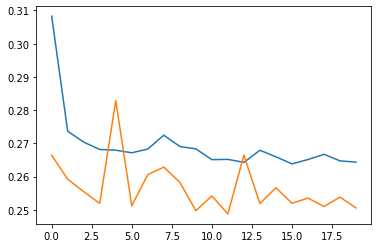

In [55]:
torch.save(model.state_dict(), 'model-combined-lstm2.pth')
plt.plot(master_train_loss[:], label='train')
plt.plot(master_valid_loss[:], label='valid')

In [56]:
with open('train_loss.pkl', 'wb') as f:
    pickle.dump(master_train_loss, f)
with open('valid_loss.pkl', 'wb') as f:
    pickle.dump(master_valid_loss, f)